In [131]:
import numpy as np
import itertools

import pymc3 as pm
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeJoint, MakeMixture, MakeNormalPmf, Beta
import thinkplot

# Simple model (Bradley-Terry)

Each team is represented by a single number $\beta_i$ where the probability that a judge ranks $i>j$ is 

$P(i > j) = \frac{e^{\beta_i}}{e^{\beta_i} + e^{\beta_j}}$

[source](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)

In [128]:
def prob_wins(winner_score, loser_score, judge_score):
    p_bt = np.exp(winner_score) / (np.exp(winner_score)+np.exp(loser_score))
    return judge_score * p_bt + (1-judge_score) * (1-p_bt)

class Tournament(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        """
        hypo is a tuple of lists (list of the scores of all teams, list of scores of judges)
        """
        judge, winner, loser = data
        teams, judges = hypo
        
        return prob_wins_grid(teams[winner], teams[loser], judges[judge])

In [129]:
def MakeJointMany(dist, n):
    pmf = Pmf()
    for vals in itertools.product(dist.Items(), repeat=n):
        pmf.Incr(tuple([val for val, p in vals]), np.product([p for val, p in vals]))
    return pmf

MakeJointMany(Pmf('xy'), 2)

Pmf({('x', 'x'): 0.25, ('x', 'y'): 0.25, ('y', 'x'): 0.25, ('y', 'y'): 0.25})

Mean for team 0: -2.71
Mean for team 1: 2.71


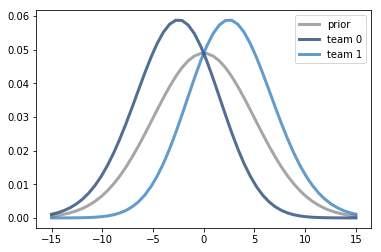

Mean for team 0: -2.71
Mean for team 1: 2.71


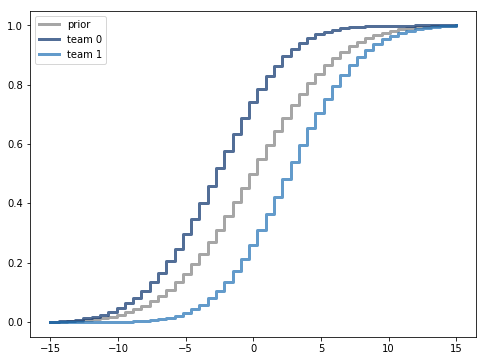

<Figure size 576x432 with 0 Axes>

In [5]:
num_teams = 2
num_judges = 1
team_prior = MakeNormalPmf(mu=0, sigma=5, num_sigmas=3, n=50)

tournament = Tournament(MakeJointMany(prior, num_teams))

tournament.Update(('me', 1, 0))
# tournament.Update(('me', 2, 1))

# Plot the output (PDF)
thinkplot.Pdf(prior, label='prior', color='grey')
for i in range(num_teams):
    marginal = tournament.Marginal(i)
    thinkplot.Pdf(marginal, label=f'team {i}')
    print(f"Mean for team {i}: {marginal.Mean():.2f}")
thinkplot.Show()

# Plot the output (CDF)
thinkplot.Cdf(prior.MakeCdf(), label='prior', color='grey')
for i in range(num_teams):
    marginal = tournament.Marginal(i)
    thinkplot.Cdf(marginal.MakeCdf(), label=f'team {i}')
    print(f"Mean for team {i}: {marginal.Mean():.2f}")
thinkplot.Show()

## MCMC method

In [6]:
from pymc3.math import exp

In [176]:
def judged_compare(teams, winner, loser):
    return pm.Binomial(f'judging_result_{winner}_v_{loser}', n=1, 
                p=exp(teams[winner]) / (exp(teams[loser])+exp(teams[winner])), observed=1)

with pm.Model() as model:
    teams = []
    for i in range(num_teams):
        teams.append(pm.Normal(f't{i}', mu=0, sd=5))
    
    judged_compare(teams, 1, 0)

Team 1 wins 50.11% of rematches


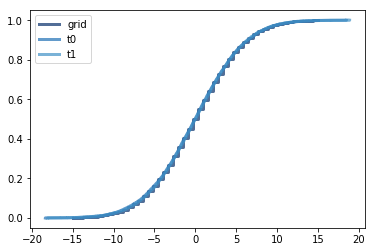

In [177]:
## Check prior

with model:
    trace_prior = pm.sample_prior_predictive(10000)

thinkplot.Cdf(prior.MakeCdf(), label='grid')
for i in range(num_teams):
    thinkplot.Cdf(Cdf(trace_prior[f't{i}']), label=f't{i}')
thinkplot.Config()

print(f"Team 1 wins {100*np.mean(trace_prior['judging_result_1_v_0'] == 1):.2f}% of rematches")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t1, t0]
Sampling 2 chains: 100%|██████████| 6600/6600 [00:07<00:00, 854.03draws/s] 


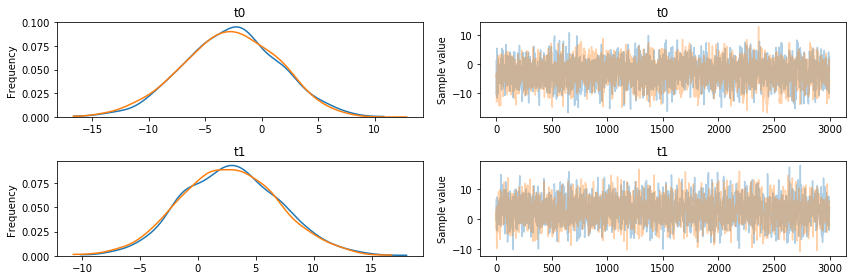

In [178]:
## Compute posterior

with model:
    trace = pm.sample(3000, tune=300)
    
pm.traceplot(trace);

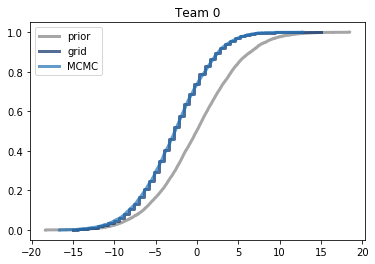

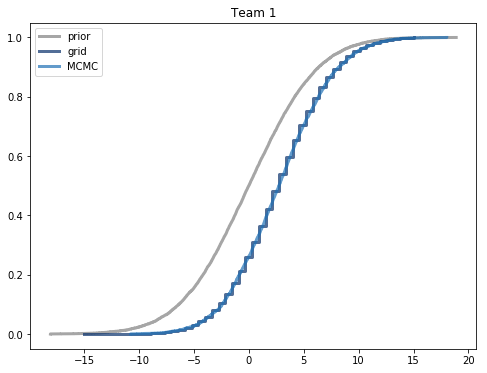

<Figure size 576x432 with 0 Axes>

In [179]:
for i in range(num_teams):
    thinkplot.Cdf(Cdf(trace_prior[f"t{i}"]), label='prior', color='grey')
    thinkplot.Cdf(tournament.Marginal(i).MakeCdf(), label='grid')
    thinkplot.Cdf(Cdf(trace[f"t{i}"]), label='MCMC')
    thinkplot.Config(title=f"Team {i}")
    thinkplot.Show()

# Judge reliability

With probability $p_j$ a judge will lie.

Taken from http://people.stern.nyu.edu/xchen3/images/crowd_pairwise.pdf

In [38]:
def judged_compare(teams, winner, loser, judges, judge):
    return pm.Binomial(f'judging_result_{winner}_v_{loser}_{judge}', n=1, 
                p=judges[judge] * exp(teams[winner]) / (exp(teams[loser])+exp(teams[winner])) +
                  (1-judges[judge]) * exp(teams[loser]) / (exp(teams[loser])+exp(teams[winner])), observed=1)

num_teams = 3
num_judges = 1

with pm.Model() as model:
    teams = []
    for i in range(num_teams):
        teams.append(pm.Normal(f't{i}', mu=0, sd=5))
    
    judges = []
    for i in range(num_judges):
        judges.append(pm.Beta(f'j{i}', mu=0.8, sd=0.1))

    judged_compare(teams, 1, 0, judges, 0)
    judged_compare(teams, 2, 1, judges, 0)
    judged_compare(teams, 0, 2, judges, 0)

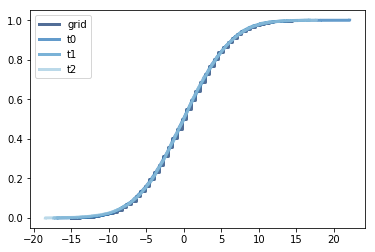

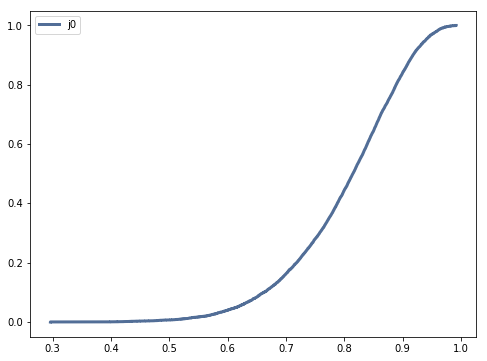

Team 1 wins 49.39% of rematches


<Figure size 576x432 with 0 Axes>

In [39]:
## Check prior

with model:
    trace_prior = pm.sample_prior_predictive(10000)

thinkplot.Cdf(prior.MakeCdf(), label='grid')
for i in range(num_teams):
    thinkplot.Cdf(Cdf(trace_prior[f't{i}']), label=f't{i}')
thinkplot.Config()
thinkplot.Show()

for i, _ in enumerate(judges):
    thinkplot.Cdf(Cdf(trace_prior[f'j{i}']), label=f'j{i}')
thinkplot.Config()
thinkplot.Show()

print(f"Team 1 wins {100*np.mean(trace_prior['judging_result_1_v_0_0'] == 1):.2f}% of rematches")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [j0, t2, t1, t0]
Sampling 2 chains: 100%|██████████| 6600/6600 [00:06<00:00, 1065.59draws/s]


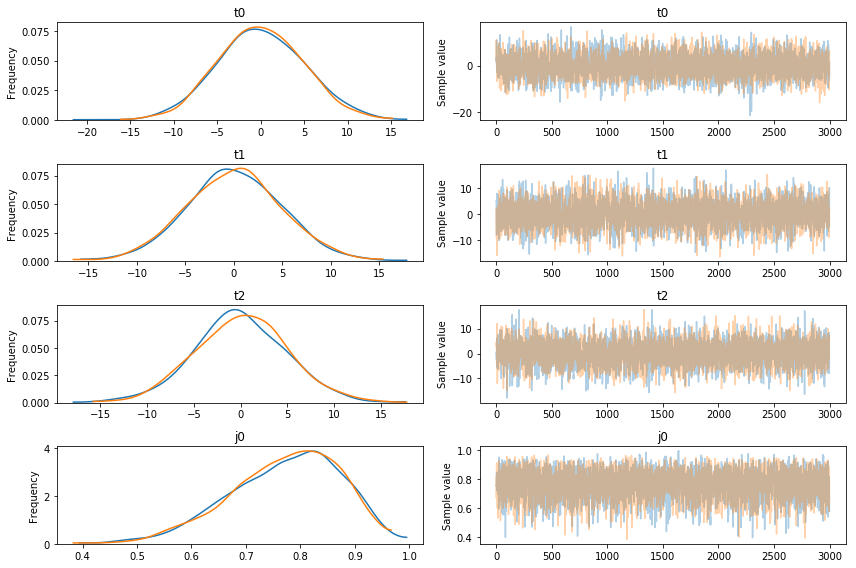

In [40]:
## Compute posterior

with model:
    trace = pm.sample(3000, tune=300)
    
pm.traceplot(trace);

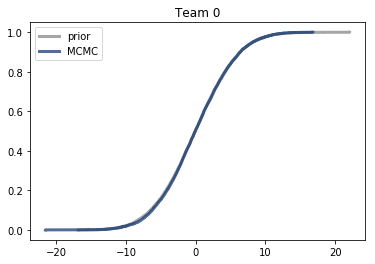

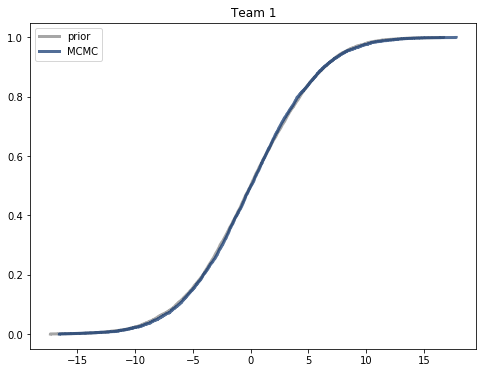

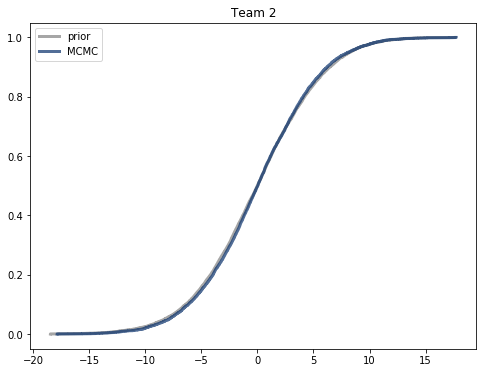

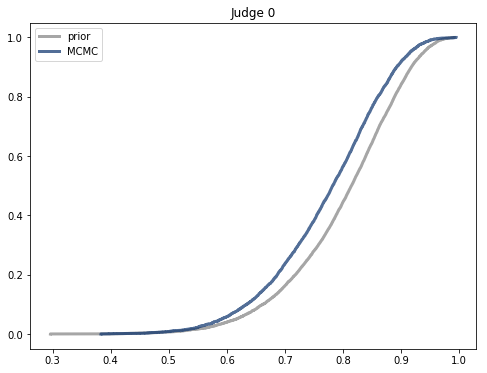

<Figure size 576x432 with 0 Axes>

In [42]:
for i in range(num_teams):
    thinkplot.Cdf(Cdf(trace_prior[f"t{i}"]), label='prior', color='grey')
    thinkplot.Cdf(Cdf(trace[f"t{i}"]), label='MCMC')
    thinkplot.Config(title=f"Team {i}")
    thinkplot.Show()

for i, _ in enumerate(judges):
    thinkplot.Cdf(Cdf(trace_prior[f"j{i}"]), label='prior', color='grey')
    thinkplot.Cdf(Cdf(trace[f"j{i}"]), label='MCMC')
    thinkplot.Config(title=f"Judge {i}")
    thinkplot.Show()


# From data

In [45]:
import pandas as pd
from pathlib import Path

In [102]:
# df = pd.read_csv(Path('../data/judging-data-hackmit.csv'))
df = pd.read_csv(Path('../data/blueprint-rookie-data.csv'))
print(len(df))
df.head()

235


,winner,loser,annotator
0,762c,0815,na
1,3f1b,0965,na
2,70ff,2845,na
3,70ef,c0d7,na
4,9f2b,2845,na


In [107]:
def judged_compare(teams, winner, loser, judges, judge, num_comparisons):
    p_bt = exp(teams[winner]) / (exp(teams[loser])+exp(teams[winner]))
    return pm.Binomial(f'judging_result_{winner}_v_{loser}_{judge}_{num_comparisons}', n=1, 
                p=judges[judge] * p_bt + (1-judges[judge]) * (1-p_bt), observed=1)

def make_model(data):
    """
    data is a list of named tuples containing "annotator", "loser", and "winner" elements
    """
    with pm.Model() as model:
        teams = {}
        for i in set((r.winner for r in data)).union(set((r.loser for r in data))):
            teams[i] = pm.Normal(f't_{i}', mu=0, sd=5)

        judges = {}
        for i in set((r.annotator for r in data)):
            judges[i] = pm.Beta(f'j_{i}', mu=0.8, sd=0.1)

        for i, r in enumerate(data):
            judged_compare(teams, r.winner, r.loser, 
                           judges, r.annotator, i)
        
    return model, judges, teams

In [119]:
model, judges, teams = make_model(list(df.itertuples())[:])

In [125]:
with model:
    trace_prior = pm.sample_prior_predictive(1000)

In [120]:
## Check prior
with model:
    trace_prior = pm.sample_prior_predictive(1000)

thinkplot.Cdf(prior.MakeCdf(), label='grid')
for i in teams:
    thinkplot.Cdf(Cdf(trace_prior[f't_{i}']), label=f't_{i}')
thinkplot.Config()
thinkplot.Show()

for i in judges:
    thinkplot.Cdf(Cdf(trace_prior[f'j_{i}']), label=f'j_{i}')
thinkplot.Config()
thinkplot.Show()

# print(f"Team 1 wins {100*np.mean(trace_prior['judging_result_1_v_0_0'] == 1):.2f}% of rematches")

KeyboardInterrupt: 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/eric/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/eric/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/eric/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/eric/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [j_na, t_26e4, t_b568, t_c096, t_0815, t_96b9, t_6500, t_21d7, t_dc51, t_da90, t_70ff, t_75f9, t_762c, t_2845, t_e212, t_9f2b, t_c0d7, t_70ef, t_eb0e, t_0965, t_dc8e, t_945d, t_bbdd, t_ecba, t_a46f, t_a4d8, t_1a2a, t_3f1b, t_91b2, t_3c11, t_fb8d, 

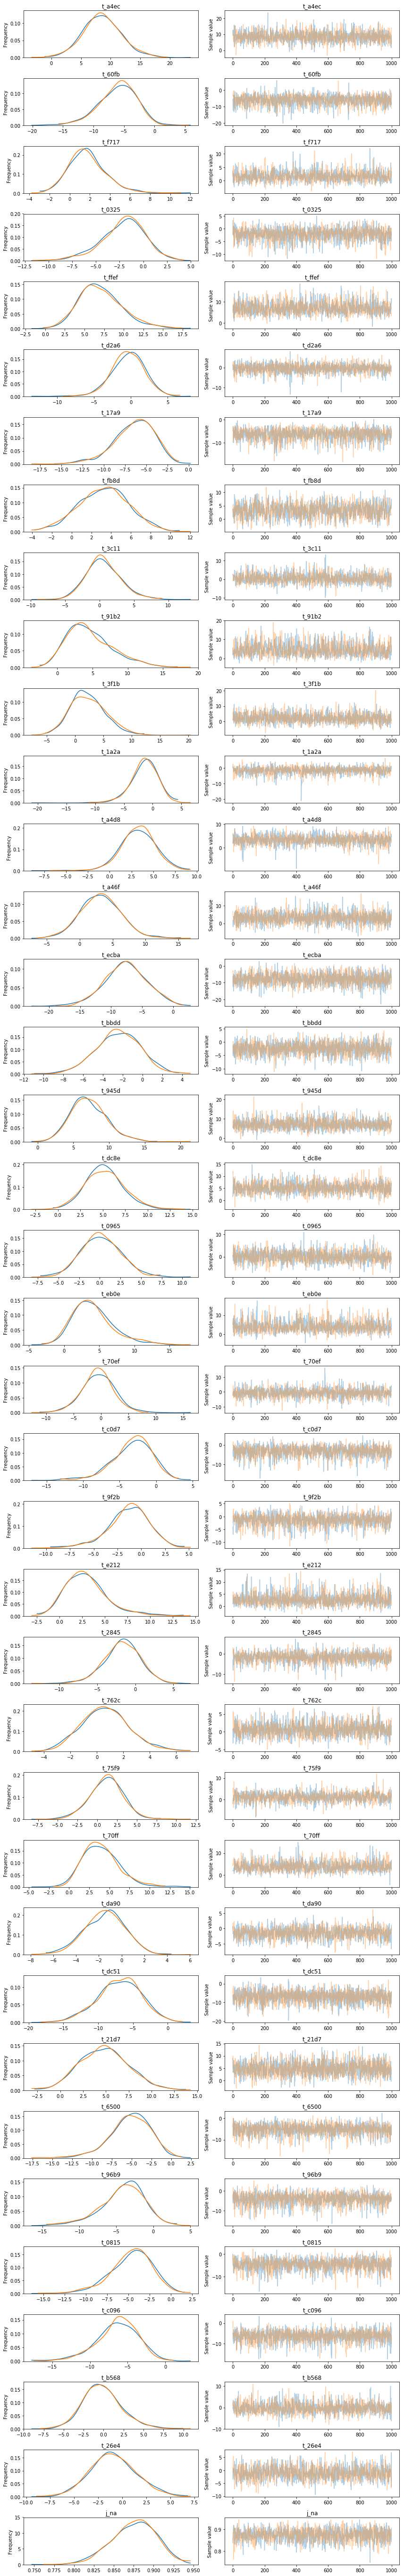

In [122]:
## Compute posterior

with model:
    trace = pm.sample(1000, tune=300)
    
pm.traceplot(trace);

/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/miniconda3/envs/ThinkBayes2/lib/python3.6/site-packages/thinkplot/thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')
/home/eric/mini

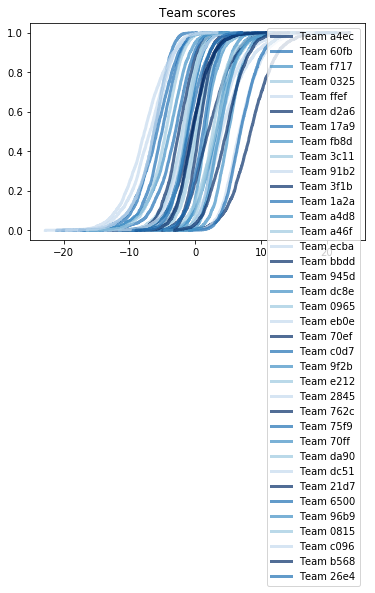

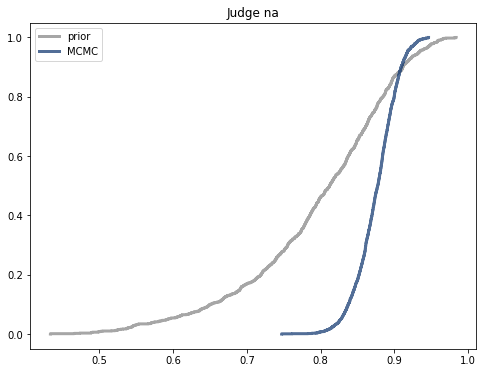

<Figure size 576x432 with 0 Axes>

In [127]:
for i in teams:
    thinkplot.Cdf(Cdf(trace[f"t_{i}"]), label=f'Team {i}')
    thinkplot.Config(title=f"Team scores")
thinkplot.Show()

for i in judges:
    thinkplot.Cdf(Cdf(trace[f"j_{i}"]), label='MCMC')
    thinkplot.Config(title=f"Judge {i}")
    thinkplot.Show()

In [134]:
len(trace)

1000

In [148]:
def compute_winners(trace):
    teams = [n for n in trace.varnames if n.startswith('t_')]
    winners = []
    for i in range(len(trace)):
        winners.append(max(teams, key=lambda team: trace[team][i]))
    return winners

winners = compute_winners(trace)

In [155]:
from collections import Counter

w = Counter(winners)
w.most_common()

[('t_a4ec', 413),
 ('t_ffef', 159),
 ('t_945d', 139),
 ('t_91b2', 87),
 ('t_eb0e', 57),
 ('t_21d7', 30),
 ('t_dc8e', 25),
 ('t_a46f', 22),
 ('t_e212', 20),
 ('t_70ff', 20),
 ('t_3f1b', 12),
 ('t_70ef', 4),
 ('t_f717', 3),
 ('t_fb8d', 3),
 ('t_b568', 2),
 ('t_3c11', 2),
 ('t_0965', 1),
 ('t_a4d8', 1)]